# RecSys Challenge 2025 — Knowledge Mining Add-on (Preprocessed Variant)

This notebook **extends** `src/EDA/eda.ipynb` with extra **knowledge mining** blocks that are directly useful for:

- **ALS** candidate generation + reranking  
- **LightFM** item/user features  
- **Transformer** sequence modeling (UBP)  

The focus here is on **patterns** (co-occurrence, transitions, intent -> purchase)


## 0. Setup

In [2]:
import re
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# modeling
import duckdb
from scipy import sparse
from sklearn.feature_extraction import FeatureHasher
from sklearn.cluster import MiniBatchKMeans


## 1. Paths and loading

In [3]:
DATA_DIR = Path("challenge_dataset")

PATHS = {
    "product_properties": DATA_DIR / "product_properties.parquet",
    "input_buy": DATA_DIR / "input" / "product_buy.parquet",
    "input_add": DATA_DIR / "input" / "add_to_cart.parquet",
    "input_remove": DATA_DIR / "input" / "remove_from_cart.parquet",
    "input_page": DATA_DIR / "input" / "page_visit.parquet",
    "input_search": DATA_DIR / "input" / "search_query.parquet",
    "relevant_clients": DATA_DIR / "input" / "relevant_clients.npy",
    "train_target": DATA_DIR / "target" / "train_target.parquet",
    "val_target": DATA_DIR / "target" / "validation_target.parquet",
    "active_clients": DATA_DIR / "target" / "active_clients.npy",
}


for k, p in PATHS.items():
    assert p.exists(), f"Missing: {k} -> {p}"

con = duckdb.connect(database=":memory:")

In [4]:
relevant_clients = np.load(PATHS["relevant_clients"])
active_clients = np.load(PATHS["active_clients"])

print("relevant_clients:", relevant_clients.shape, relevant_clients.dtype, "| unique:", np.unique(relevant_clients).shape[0])
print("active_clients:", active_clients.shape, active_clients.dtype, "| active ⊆ relevant:", np.isin(active_clients, relevant_clients).mean())

relevant_clients: (1000000,) int64 | unique: 1000000
active_clients: (744980,) int64 | active ⊆ relevant: 0.685885527128245


## 2. Product properties: what metadata we can mine

In [5]:
props = con.execute(f'''
    SELECT sku, category, price, name
    FROM read_parquet('{PATHS["product_properties"].as_posix()}')
''').fetchdf()

props["sku"] = props["sku"].astype("int64")
props["category"] = props["category"].astype("int64")
props["price"] = props["price"].astype("int64")

print("product_properties:", props.shape)
props.head(3)

product_properties: (1260365, 4)


,sku,category,price,name
0,101733,6552,13,[131 245 189 142 164 164 138 254 91 83 80 1...
1,184680,6153,59,[219 48 162 96 67 72 96 44 12 250 7 2...
2,540546,618,99,[ 56 212 52 212 212 212 212 19 212 212 212 1...


In [6]:
pq_len = props["name"].astype(str).str.findall(r"-?\d+").str.len()
print("PQ column:", "name")
print(pq_len.value_counts().head(10))

PQ column: name
name
16    1260365
Name: count, dtype: int64


## 3. Cold-start pressure (targets vs input)

In [7]:
input_skus = con.execute(f'''
    SELECT DISTINCT CAST(sku AS BIGINT) AS sku
    FROM read_parquet('{PATHS["input_buy"].as_posix()}')
    UNION
    SELECT DISTINCT CAST(sku AS BIGINT) AS sku
    FROM read_parquet('{PATHS["input_add"].as_posix()}')
    UNION
    SELECT DISTINCT CAST(sku AS BIGINT) AS sku
    FROM read_parquet('{PATHS["input_remove"].as_posix()}')
''').fetchdf()["sku"].astype("int64").values

input_sku_set = set(input_skus.tolist())
print("Unique SKUs in input:", len(input_sku_set))

Unique SKUs in input: 1260365


In [8]:
train_skus = con.execute(f'''
    SELECT DISTINCT CAST(sku AS BIGINT) AS sku
    FROM read_parquet('{PATHS["train_target"].as_posix()}')
''').fetchdf()["sku"].astype("int64").values

val_skus = con.execute(f'''
    SELECT DISTINCT CAST(sku AS BIGINT) AS sku
    FROM read_parquet('{PATHS["val_target"].as_posix()}')
''').fetchdf()["sku"].astype("int64").values

train_unseen = np.array([s for s in train_skus if s not in input_sku_set], dtype=np.int64)
val_unseen   = np.array([s for s in val_skus if s not in input_sku_set], dtype=np.int64)

print(f"Train target SKUs: {len(train_skus):,} | unseen: {len(train_unseen):,} ({len(train_unseen)/len(train_skus):.2%})")
print(f"Val target SKUs:   {len(val_skus):,} | unseen: {len(val_unseen):,} ({len(val_unseen)/len(val_skus):.2%})")

Train target SKUs: 109,685 | unseen: 38,635 (35.22%)
Val target SKUs:   116,852 | unseen: 52,664 (45.07%)


**We can see:** SKU-level models are capped by cold-start. Category/price/query-intent patterns are the stable backbone; SKU factors act as local refinements.

## 4. Knowledge mining | category co-occurrence graph (session baskets)

We build session baskets for a sample of users and mine **category pairs**.  
This produces a compact graph that is easy to plug into reranking / feature engineering.

In [9]:
rng = np.random.default_rng(42)
USER_SAMPLE = 20_000
user_sample = rng.choice(active_clients, size=min(USER_SAMPLE, len(active_clients)), replace=False).astype("int64")

users_df = pd.DataFrame({"client_id": user_sample})
con.register("users_df", users_df)

print("Sampled users:", len(user_sample))

Sampled users: 20000


Load cart-related events for sampled users

In [10]:
events_cart = con.execute(f'''
    SELECT
        CAST(e.client_id AS BIGINT) AS client_id,
        try_cast(e.timestamp AS TIMESTAMP) AS ts,
        CAST(e.sku AS BIGINT) AS sku,
        'add' AS event_type
    FROM read_parquet('{PATHS["input_add"].as_posix()}') e
    JOIN users_df u ON CAST(e.client_id AS BIGINT) = u.client_id

    UNION ALL

    SELECT
        CAST(e.client_id AS BIGINT) AS client_id,
        try_cast(e.timestamp AS TIMESTAMP) AS ts,
        CAST(e.sku AS BIGINT) AS sku,
        'buy' AS event_type
    FROM read_parquet('{PATHS["input_buy"].as_posix()}') e
    JOIN users_df u ON CAST(e.client_id AS BIGINT) = u.client_id

    UNION ALL

    SELECT
        CAST(e.client_id AS BIGINT) AS client_id,
        try_cast(e.timestamp AS TIMESTAMP) AS ts,
        CAST(e.sku AS BIGINT) AS sku,
        'remove' AS event_type
    FROM read_parquet('{PATHS["input_remove"].as_posix()}') e
    JOIN users_df u ON CAST(e.client_id AS BIGINT) = u.client_id
''').fetchdf()

events_cart = events_cart.dropna(subset=["ts", "sku"])
events_cart["client_id"] = events_cart["client_id"].astype("int64")
events_cart["sku"] = events_cart["sku"].astype("int64")

print("Cart events (sample):", events_cart.shape)
events_cart.head(3)

Cart events (sample): (149263, 4)


,client_id,ts,sku,event_type
0,18002411,2022-07-28 13:11:20,628789,add
1,17799109,2022-07-28 13:11:20,680368,add
2,18002411,2022-07-28 13:11:40,397925,add


Map sku -> category

In [11]:
sku_to_cat = props.set_index("sku")["category"].to_dict()

events_cart["category"] = events_cart["sku"].map(sku_to_cat).astype("float")
events_cart = events_cart.dropna(subset=["category"]).copy()
events_cart["category"] = events_cart["category"].astype("int64")

events_cart = events_cart.sort_values(["client_id", "ts"]).reset_index(drop=True)
events_cart.head(3)

,client_id,ts,sku,event_type,category
0,5490,2022-10-11 12:39:30,1596134,add,2964
1,5490,2022-10-11 12:43:30,1596134,add,2964
2,5490,2022-10-11 12:43:40,1596134,remove,2964


Sessionize by time gap

In [12]:
GAP_MINUTES = 30

dt = events_cart.groupby("client_id")["ts"].diff()
new_sess = (dt.isna()) | (dt > pd.Timedelta(minutes=GAP_MINUTES))

events_cart["session_id"] = new_sess.groupby(events_cart["client_id"]).cumsum().astype("int64")
events_cart["session_key"] = events_cart["client_id"].astype(str) + "_" + events_cart["session_id"].astype(str)

sess_sizes = events_cart.groupby("session_key")["category"].nunique()
print("Sessions:", sess_sizes.shape[0])
print("Share sessions with >=2 categories:", (sess_sizes >= 2).mean())

Sessions: 44615
Share sessions with >=2 categories: 0.23839515857895327


Build category basket matrix (dedup per session)

In [13]:
basket = events_cart.drop_duplicates(["session_key", "category"])[["session_key", "category"]]

TOPN_CATS = 2000
cat_counts = basket["category"].value_counts()
top_cats = cat_counts.head(TOPN_CATS).index.to_numpy(dtype=np.int64)
basket = basket[basket["category"].isin(top_cats)]

sess_ids = pd.Index(basket["session_key"].unique())
cat_ids = pd.Index(top_cats)

sess_map = pd.Series(np.arange(len(sess_ids)), index=sess_ids)
cat_map = pd.Series(np.arange(len(cat_ids)), index=cat_ids)

rows = sess_map[basket["session_key"]].values
cols = cat_map[basket["category"]].values

X = sparse.csr_matrix(
    (np.ones(len(rows), dtype=np.float32), (rows, cols)),
    shape=(len(sess_ids), len(cat_ids))
)
X.data[:] = 1.0

print("Basket matrix:", X.shape, "| nnz:", X.nnz)

Basket matrix: (42696, 2000) | nnz: 64848


Co-occurrence counts + lift

In [14]:
C = (X.T @ X).tocsr()
C.setdiag(0)
C.eliminate_zeros()

cat_freq = np.asarray(X.sum(axis=0)).ravel()
n_sess = X.shape[0]

coo = C.tocoo()
pairs = pd.DataFrame({"i": coo.row, "j": coo.col, "cnt": coo.data.astype(np.int64)})
pairs = pairs[pairs["i"] < pairs["j"]].copy()

pairs["lift"] = (pairs["cnt"] * n_sess) / (cat_freq[pairs["i"].values] * cat_freq[pairs["j"].values] + 1e-9)

idx_to_cat = dict(enumerate(cat_ids.tolist()))
pairs["cat_i"] = pairs["i"].map(idx_to_cat)
pairs["cat_j"] = pairs["j"].map(idx_to_cat)

pairs = pairs.sort_values(["lift", "cnt"], ascending=False)
pairs.head(20)[["cat_i", "cat_j", "cnt", "lift"]]

,cat_i,cat_j,cnt,lift
78989,1389,2442,4,5692.800000
80336,1421,3306,3,5123.520000
77132,6176,1421,4,4879.542857
75868,2865,2442,3,3659.657143
75885,1842,1421,3,3659.657143
75886,1842,3306,3,3659.657143
76059,5670,83,3,3659.657143
77133,6176,3306,3,3659.657143
77812,6901,1464,3,3558.000000
79533,2716,170,2,3415.680000


High-lift pairs form a reliable pairing/goes-with graph. 
 
This is useful when SKU-level pairs are sparse and cold-start is heavy.

Persist for model code

In [15]:
ART_DIR = DATA_DIR / "artifacts_knowledge_mining"
ART_DIR.mkdir(parents=True, exist_ok=True)

pairs_out = pairs[["cat_i", "cat_j", "cnt", "lift"]].head(200_000)
pairs_out.to_parquet(ART_DIR / "cat_cooc_lift_top200k.parquet", index=False)

print("Saved:", ART_DIR / "cat_cooc_lift_top200k.parquet")

Saved: challenge_dataset/artifacts_knowledge_mining/cat_cooc_lift_top200k.parquet


## 5. Knowledge mining | category transitions (buy sequences)

We mine **ordered transitions** from buy events.  
These transitions translate naturally into sequence tokens for Transformers and into priors for reranking.

In [16]:
buy_ev = con.execute(f'''
    SELECT
        CAST(e.client_id AS BIGINT) AS client_id,
        try_cast(e.timestamp AS TIMESTAMP) AS ts,
        CAST(e.sku AS BIGINT) AS sku
    FROM read_parquet('{PATHS["input_buy"].as_posix()}') e
    JOIN users_df u ON CAST(e.client_id AS BIGINT) = u.client_id
''').fetchdf()

buy_ev = buy_ev.dropna(subset=["ts", "sku"]).copy()
buy_ev["client_id"] = buy_ev["client_id"].astype("int64")
buy_ev["sku"] = buy_ev["sku"].astype("int64")

buy_ev["category"] = buy_ev["sku"].map(sku_to_cat).astype("float")
buy_ev = buy_ev.dropna(subset=["category"]).copy()
buy_ev["category"] = buy_ev["category"].astype("int64")

buy_ev = buy_ev.sort_values(["client_id", "ts"]).reset_index(drop=True)
print("Buy events (sample):", buy_ev.shape)
buy_ev.head(3)

Buy events (sample): (47768, 4)


,client_id,ts,sku,category
0,5490,2022-10-11 12:48:35,1596134,2964
1,5618,2022-08-12 07:52:20,554556,2325
2,9269,2022-10-29 10:28:30,51155,3407


Bigram transitions per user

In [17]:
src = buy_ev.groupby("client_id")["category"].shift(0)
dst = buy_ev.groupby("client_id")["category"].shift(-1)

trans = pd.DataFrame({"src": src, "dst": dst}).dropna().astype("int64")

trans_counts = trans.value_counts().rename("cnt").reset_index()
trans_counts = trans_counts.sort_values("cnt", ascending=False)
trans_counts.head(20)

,src,dst,cnt
0,1966,1966,374
1,1096,1096,325
2,258,258,309
3,4092,4092,147
4,2964,2964,139
5,3138,3138,137
6,791,791,121
7,6356,6356,117
8,384,384,107
9,5858,5858,100


Normalize by outgoing mass: P(dst | src)

In [18]:
out_mass = trans_counts.groupby("src")["cnt"].sum().rename("out_cnt")
trans_p = trans_counts.merge(out_mass, on="src", how="left")
trans_p["p"] = trans_p["cnt"] / trans_p["out_cnt"]

trans_p.sort_values(["p", "cnt"], ascending=False).head(30)

,src,dst,cnt,out_cnt,p
144,6511,6511,18,18,1.0
227,2974,2974,13,13,1.0
244,3970,3970,12,12,1.0
332,4736,4736,9,9,1.0
335,4963,4963,9,9,1.0
481,2682,2682,6,6,1.0
496,4299,4299,6,6,1.0
534,833,833,6,6,1.0
542,6385,6385,6,6,1.0
572,4222,4222,5,5,1.0


For Transformers, adding `CAT_{id}` tokens and learning next-category improves generalization under SKU cold-start.

In [19]:
trans_p.to_parquet(ART_DIR / "buy_category_transitions.parquet", index=False)
print("Saved:", ART_DIR / "buy_category_transitions.parquet")

Saved: challenge_dataset/artifacts_knowledge_mining/buy_category_transitions.parquet


## 6. Knowledge mining | query intent clusters -> purchased categories

We cluster PQ query codes into **intent buckets**, then match each search to the **next buy** within a time window.

In [20]:
SEARCH_SAMPLE_ROWS = 300_000
WINDOW_H = 24
N_CLUSTERS = 128

search_df = con.execute(f'''
    SELECT
        row_number() OVER () AS sid,
        CAST(client_id AS BIGINT) AS client_id,
        try_cast(timestamp AS TIMESTAMP) AS ts,
        query
    FROM read_parquet('{PATHS["input_search"].as_posix()}')
    WHERE timestamp IS NOT NULL
    LIMIT {SEARCH_SAMPLE_ROWS}
''').fetchdf()

search_df = search_df.dropna(subset=["ts"]).copy()
search_df["client_id"] = search_df["client_id"].astype("int64")

print("Sampled searches:", search_df.shape)
search_df.head(3)

Sampled searches: (300000, 4)


,sid,client_id,ts,query
0,1,12965754,2022-06-23 00:10:00,[202 151 206 232 232 181 181 55 9 57 236 ...
1,2,12965754,2022-06-23 00:10:05,[202 151 206 232 232 181 181 55 9 57 236 ...
2,3,14797776,2022-06-23 00:10:05,[168 151 190 159 215 117 50 9 147 168 94 2...


Tokenize PQ code string

In [21]:
_num_re = re.compile(r"-?\d+")

def to_tokens(q) -> list[str]:
    return [f"c{m}" for m in _num_re.findall(str(q))]

tokens = [to_tokens(q) for q in search_df["query"].tolist()]
Xq = FeatureHasher(n_features=1024, input_type="string").transform(tokens)

print("Hashed query matrix:", Xq.shape, "| nnz:", Xq.nnz)

Hashed query matrix: (300000, 1024) | nnz: 3087161


Cluster intents

In [22]:
km = MiniBatchKMeans(n_clusters=N_CLUSTERS, batch_size=4096, random_state=42)
search_df["q_cluster"] = km.fit_predict(Xq)

search_df["q_cluster"].value_counts().head(10)

q_cluster
17     15855
3      13169
20     10260
94      8806
107     8193
0       5888
88      5417
26      5368
44      5318
117     5175
Name: count, dtype: int64

We can also use DuckDB windowing to match each search to the next buy within WINDOW_H 

In [23]:
con.register("search_sample", search_df[["sid", "client_id", "ts", "q_cluster"]])

matched = con.execute(f'''
WITH b AS (
    SELECT
        CAST(client_id AS BIGINT) AS client_id,
        try_cast(timestamp AS TIMESTAMP) AS buy_ts,
        CAST(sku AS BIGINT) AS sku
    FROM read_parquet('{PATHS["input_buy"].as_posix()}')
    WHERE timestamp IS NOT NULL
      AND client_id IN (SELECT DISTINCT client_id FROM search_sample)
),
j AS (
    SELECT
        s.sid, s.client_id, s.ts, s.q_cluster,
        b.sku, b.buy_ts,
        row_number() OVER (PARTITION BY s.sid ORDER BY b.buy_ts) AS rn
    FROM search_sample s
    LEFT JOIN b
      ON b.client_id = s.client_id
     AND b.buy_ts >= s.ts
     AND b.buy_ts <= s.ts + INTERVAL '{WINDOW_H} hours'
)
SELECT sid, client_id, ts, q_cluster, sku, buy_ts
FROM j
WHERE rn = 1 AND sku IS NOT NULL
''').fetchdf()

print("Matched search→buy pairs:", matched.shape[0], "from sampled searches:", search_df.shape[0])
matched.head(3)

Matched search→buy pairs: 31394 from sampled searches: 300000


,sid,client_id,ts,q_cluster,sku,buy_ts
0,108594,9154141,2022-06-25 15:21:20,99,554662,2022-06-25 15:33:25
1,108626,19872491,2022-06-25 15:21:55,112,197856,2022-06-25 15:22:30
2,108709,18245251,2022-06-25 15:23:20,79,376900,2022-06-25 15:45:10


In [24]:
matched["sku"] = matched["sku"].astype("int64")
matched["category"] = matched["sku"].map(sku_to_cat)

m = matched.dropna(subset=["category"]).copy()
m["category"] = m["category"].astype("int64")

top_cat_per_cluster = (
    m.groupby("q_cluster")["category"]
     .value_counts()
     .groupby(level=0)
     .head(5)
     .rename("cnt")
     .reset_index()
)

top_cat_per_cluster.head(30)

,q_cluster,category,cnt
0,0,5131,23
1,0,2243,16
2,0,4898,16
3,0,4072,15
4,0,5835,14
5,1,4092,20
6,1,3576,19
7,1,6853,16
8,1,3554,12
9,1,2239,8


Cluster-level conversion rate

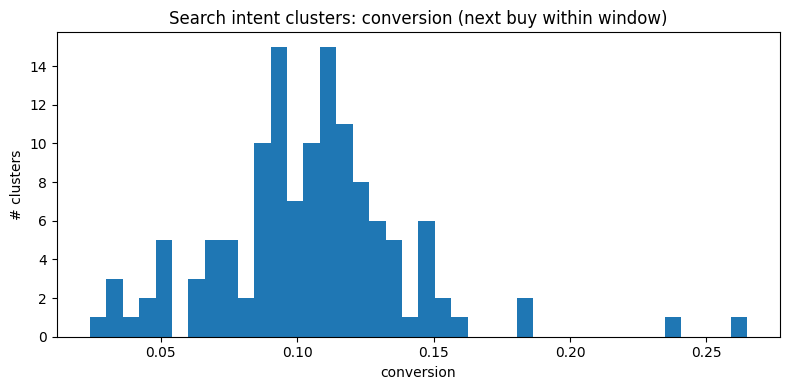

,q_cluster,n_search,n_hit,conv
124,84,385,102,0.264935
126,100,338,80,0.236686
125,37,381,71,0.186352
44,59,2164,392,0.181146
36,33,2642,414,0.156699
111,71,844,132,0.156398
81,125,1300,200,0.153846
76,11,1386,208,0.150072
52,102,1985,296,0.149118
109,15,872,129,0.147936


In [25]:
cluster_size = search_df["q_cluster"].value_counts().rename("n_search").reset_index().rename(columns={"index": "q_cluster"})
cluster_hit  = matched["q_cluster"].value_counts().rename("n_hit").reset_index().rename(columns={"index": "q_cluster"})

conv = cluster_size.merge(cluster_hit, on="q_cluster", how="left").fillna(0)
conv["n_hit"] = conv["n_hit"].astype("int64")
conv["conv"] = conv["n_hit"] / conv["n_search"]

plt.figure(figsize=(8, 4))
plt.hist(conv["conv"].values, bins=40)
plt.title("Search intent clusters: conversion (next buy within window)")
plt.xlabel("conversion"); plt.ylabel("# clusters")
plt.tight_layout()
plt.show()

conv.sort_values("conv", ascending=False).head(10)

Query clusters provide a user-intent signal that is not tied to SKU IDs

This is a clean bridge from search logs to SKU cold-start: `cluster -> category`.

In [26]:
top_cat_per_cluster.to_parquet(ART_DIR / "query_cluster_top_categories.parquet", index=False)
conv.to_parquet(ART_DIR / "query_cluster_conversion.parquet", index=False)

## 7. Knowledge Mining | Creating Embeddings | Category Graph

We convert the mined category co-occurrence graph into an extra user embedding:
1) aggregate per-user category affinity from buy/add/remove (weighted),
2) diffuse it through the category graph (hashed adjacency),
3) save as `client_ids.npy` + `embeddings.npy` so it can be added to `merge.yaml`.

This block is stable under SKU cold-start because it works in category space.


In [27]:
D = 256 # our embedding dim
TOP_EDGES = 200000

cat_edges = pd.read_parquet(ART_DIR / "cat_cooc_lift_top200k.parquet").head(TOP_EDGES)

Build small D x D matrix by hashing categories -> buckets

In [28]:
P = np.zeros((D, D), dtype=np.float32)

for r in cat_edges.itertuples(index=False):
    a = int(r.cat_i) % D
    b = int(r.cat_j) % D
    w = float(r.lift)

    P[a, b] += w
    P[b, a] += w

Row-normalize so it behaves like a diffusion operator

In [29]:
row_sum = P.sum(axis=1, keepdims=True) + 1e-9
P = P / row_sum

aggregate per-user category affinity

In [30]:
W_BUY = 3.0
W_ADD = 1.0
W_REM = -0.5

# user universe for this embedding:
# using active clients keeps it smaller; merge script pads/imputes for missing relevant users.
user_ids = np.sort(active_clients.astype(np.int64))
con.register("users_df", pd.DataFrame({"client_id": user_ids}))

# sku -> category table in duckdb
props_small = props[["sku", "category"]].copy()
con.register("props_small", props_small)

agg = con.execute(f"""
WITH buy AS (
  SELECT CAST(e.client_id AS BIGINT) AS client_id, CAST(p.category AS BIGINT) AS category, {W_BUY}::DOUBLE AS w
  FROM read_parquet('{PATHS["input_buy"].as_posix()}') e
  JOIN users_df u ON CAST(e.client_id AS BIGINT) = u.client_id
  JOIN props_small p ON CAST(e.sku AS BIGINT) = CAST(p.sku AS BIGINT)
),
add AS (
  SELECT CAST(e.client_id AS BIGINT) AS client_id, CAST(p.category AS BIGINT) AS category, {W_ADD}::DOUBLE AS w
  FROM read_parquet('{PATHS["input_add"].as_posix()}') e
  JOIN users_df u ON CAST(e.client_id AS BIGINT) = u.client_id
  JOIN props_small p ON CAST(e.sku AS BIGINT) = CAST(p.sku AS BIGINT)
),
rem AS (
  SELECT CAST(e.client_id AS BIGINT) AS client_id, CAST(p.category AS BIGINT) AS category, {W_REM}::DOUBLE AS w
  FROM read_parquet('{PATHS["input_remove"].as_posix()}') e
  JOIN users_df u ON CAST(e.client_id AS BIGINT) = u.client_id
  JOIN props_small p ON CAST(e.sku AS BIGINT) = CAST(p.sku AS BIGINT)
)
SELECT client_id, category, SUM(w) AS w
FROM (SELECT * FROM buy UNION ALL SELECT * FROM add UNION ALL SELECT * FROM rem)
GROUP BY 1, 2
""").fetchdf()

agg["client_id"] = agg["client_id"].astype(np.int64)
agg["category"] = agg["category"].astype(np.int64)
agg["w"] = agg["w"].astype(np.float32)

agg.head()

,client_id,category,w
0,2711615,1470,1.0
1,14400788,582,6.5
2,22439269,1135,0.5
3,9336763,4513,1.0
4,2415527,419,1.0


build hashed user embedding + diffuse via P

In [31]:
n = user_ids.shape[0]
E = np.zeros((n, D), dtype=np.float32)

# map client_id -> row index using searchsorted (ids are sorted)
row = np.searchsorted(user_ids, agg["client_id"].values)
col = (agg["category"].values % D).astype(np.int64)

# add weighted counts into hashed buckets (flat add is fast)
flat = row.astype(np.int64) * D + col
np.add.at(E.ravel(), flat, agg["w"].values)

# basic stabilization
E = np.log1p(np.maximum(E, 0.0))

# graph diffusion in hashed space
E2 = E @ P

# blend original + diffused
alpha = 0.3
E_final = (1 - alpha) * E + alpha * E2

# L2 normalize (merge can also do it, but doing it here keeps scale stable)
norm = np.linalg.norm(E_final, axis=1, keepdims=True) + 1e-12
E_final = E_final / norm

E_final.shape

(744980, 256)

In [32]:
OUT = Path("challenge_dataset/embeddings/km_catgraph_256")
OUT.mkdir(parents=True, exist_ok=True)

np.save(OUT / "client_ids.npy", user_ids.astype(np.int64, copy=False))
np.save(OUT / "embeddings.npy", E_final.astype(np.float16, copy=False))

print("saved:", OUT)

saved: challenge_dataset/embeddings/km_catgraph_256


## (Optional) Reranking using mined graphs | ALS / LightFM / Transformer

We also wanted to see how the mined patterns can be used for reranking

Mining outputs written into:

- `challenge_dataset/artifacts_knowledge_mining/cat_cooc_lift_top200k.parquet`
- `challenge_dataset/artifacts_knowledge_mining/buy_category_transitions.parquet`
- `challenge_dataset/artifacts_knowledge_mining/query_cluster_top_categories.parquet`

### Reranking with category co-occurrence graph

We used a post-processing reranker for a candidate list produced by a base model.

Input: `candidates` with columns `[client_id, sku, score]` (score = ALS/LightFM/Transformer base score).  
We map each SKU to its category and apply a category-graph prior mined from sessions:
a candidate is boosted if its category is a strong co-occurrence neighbor of the user’s top categories.

`score_rerank = (1 - alpha) * score + alpha * boost`

Where `boost` is the max lift between the candidate category and the user’s intent categories

### 7.1 ALS: rerank candidates with category graph

In [ ]:
cat_edges = pd.read_parquet(ART_DIR / "cat_cooc_lift_top200k.parquet")
cat_edges.head(3)

,cat_i,cat_j,cnt,lift
0,1389,2442,4,5692.800000
1,1421,3306,3,5123.520000
2,6176,1421,4,4879.542857


Build adj + sku_to_cat from mining outputs / product_properties

Adjacency dict: `category -> list[(neighbor_cat, lift)]`

In [ ]:
adj = {}
for r in cat_edges.itertuples(index=False):
    ci, cj, w = int(r.cat_i), int(r.cat_j), float(r.lift)
    adj.setdefault(ci, []).append((cj, w))
    adj.setdefault(cj, []).append((ci, w))

for c in list(adj.keys())[:200]:
    adj[c] = sorted(adj[c], key=lambda x: x[1], reverse=True)[:50]

print("adj categories:", len(adj))

adj categories: 1950


In [29]:
def rerank_skus_with_cat_graph(
    candidates: pd.DataFrame,
    sku_to_cat: dict[int, int],
    adj: dict[int, list[tuple[int, float]]],
    alpha: float = 0.2,
    user_topk_cats: int = 20,
    recent_cats_used: int = 10,
) -> pd.DataFrame:
    df = candidates.copy()
    df["client_id"] = df["client_id"].astype("int64")
    df["sku"] = df["sku"].astype("int64")

    df["cat"] = df["sku"].map(sku_to_cat)
    df = df.dropna(subset=["cat"]).copy()
    df["cat"] = df["cat"].astype("int64")

    df = df.sort_values(["client_id", "score"], ascending=[True, False])

    topk_cats = (
        df.groupby("client_id")["cat"]
          .head(user_topk_cats)
          .groupby(df["client_id"])
          .apply(list)
    )

    boost = np.zeros(len(df), dtype=np.float32)
    cids = df["client_id"].to_numpy()
    cats = df["cat"].to_numpy()

    for i in range(len(df)):
        recent = topk_cats.get(cids[i], [])
        b = 0.0
        for rc in recent[:recent_cats_used]:
            for nb, w in adj.get(rc, []):
                if nb == cats[i]:
                    b = max(b, w)
                    break
        boost[i] = b

    df["score_rerank"] = df["score"] * (1 - alpha) + boost * alpha
    return df.drop(columns=["cat"])

In [ ]:
# sku_to_cat = props.set_index("sku")["category"].to_dict()

# reranked = rerank_skus_with_cat_graph(candidates, sku_to_cat, adj, alpha=0.2)

# final_topk = (
#     reranked.sort_values(["client_id", "score_rerank"], ascending=[True, False])
#             .groupby("client_id")
#             .head(20)
# )

# final_topk.head()

#### Example 1
```
ALS_DIR = Path("challenge_dataset/embeddings/als_buy_add_categories")
# must contain: client_ids.npy, embeddings.npy, item_ids.npy, item_factors.npy

u_ids = np.load(ALS_DIR / "client_ids.npy").astype(np.int64)
U = np.load(ALS_DIR / "embeddings.npy").astype(np.float32)

i_ids = np.load(ALS_DIR / "item_ids.npy").astype(np.int64)
V = np.load(ALS_DIR / "item_factors.npy").astype(np.float32)

print(U.shape, V.shape)
```

Typical pattern:
1) generate top-K candidates per user with base model
2) rerank them
3) take top-K by score_rerank

```
K = 200
user_batch = 256

uids = u_ids[:user_batch]
Ub = U[:user_batch]  # (B, d)
scores = Ub @ V.T  # (B, n_items)

top_idx = np.argpartition(-scores, K, axis=1)[:, :K]
top_scores = np.take_along_axis(scores, top_idx, axis=1)

candidates = pd.DataFrame({
    "client_id": np.repeat(uids, K),
    "sku": i_ids[top_idx.reshape(-1)],
    "score": top_scores.reshape(-1).astype(np.float32),
})

candidates.head()
```


### 7.2 LightFM: item features from category / price (plus mined priors)

Item feature strings per SKU:

- `cat=...`
- `price=...`
- `nbcat=...` (top neighbor categories from `cat_cooc_lift_top200k.parquet`)

This plugs into the LightFM feature builder used in the main models code (meaning that same matrix shape, extra feature columns)


### 7.3 Transformer: sequence tokens from category transitions + query clusters

Sequence tokens that stay stable under SKU cold-start:

- event tokens: `BUY`, `ADD`, `REMOVE`, `SEARCH`, `PAGE`
- category tokens: `CAT_{id}`
- price tokens: `PRICE_{bucket}`
- query intent tokens: `QCL_{cluster}`

Mining outputs provide:

- a strong prior over category transitions (`buy_category_transitions.parquet`)
- a mapping `QCL -> top CAT` (`query_cluster_top_categories.parquet`)

This fits as:
- hard negatives from neighbor categories
- auxiliary next-category loss / intent-to-category loss


### Example 2

***KNN-on-UBP retrieval***

In [ ]:
LLM_DIR = Path(".../embeddings/small_135m_vllm")

u_ids = np.load(LLM_DIR / "client_ids.npy").astype(np.int64)
U = np.load(LLM_DIR / "embeddings.npy").astype(np.float32)

# cosine similarity + normalization
U = U / (np.linalg.norm(U, axis=1, keepdims=True) + 1e-12)

print("U:", U.shape, "uids:", u_ids.shape)

In [ ]:
Q = 8
NN = 200

q_ids = u_ids[:Q]
q_idx = np.arange(Q)

S = U[q_idx] @ U.T # (Q, N)
nn_idx = np.argpartition(-S, NN, axis=1)[:, :NN]
nn_sim = np.take_along_axis(S, nn_idx, axis=1)

nn_users = u_ids[nn_idx] # (Q, NN)
print("neighbors:", nn_users.shape)

In [ ]:
nb = pd.DataFrame({
    "q_pos": np.repeat(np.arange(Q), NN),
    "q_client_id": np.repeat(q_ids, NN),
    "nb_client_id": nn_users.reshape(-1),
    "w": nn_sim.reshape(-1).astype(np.float32),
})
con.register("nb", nb)

buy_path = PATHS["input_buy"].as_posix()

candidates = con.execute(f"""
WITH b AS (
    SELECT CAST(client_id AS BIGINT) AS client_id,
           CAST(sku AS BIGINT) AS sku
    FROM read_parquet('{buy_path}')
)
SELECT
    nb.q_client_id AS client_id,
    b.sku AS sku,
    SUM(nb.w) AS score
FROM nb
JOIN b ON b.client_id = nb.nb_client_id
GROUP BY 1, 2
""").fetchdf()

candidates["client_id"] = candidates["client_id"].astype("int64")
candidates["sku"] = candidates["sku"].astype("int64")
candidates["score"] = candidates["score"].astype("float32")

K = 500
candidates = (
    candidates.sort_values(["client_id", "score"], ascending=[True, False])
              .groupby("client_id")
              .head(K)
              .reset_index(drop=True)
)

candidates.head()

In [ ]:
reranked = rerank_skus_with_cat_graph(candidates, sku_to_cat, adj, alpha=0.2)

TOPK = 20
final_topk = (
    reranked.sort_values(["client_id", "score_rerank"], ascending=[True, False])
            .groupby("client_id")
            .head(TOPK)
)

final_topk.head(40)